In [1]:
# Connection with Google Drive
from google.colab import drive
 
#drive.mount('/content/drive')

In [2]:
# Installation of packages
!pip install lazypredict
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Import packages
from google.colab import files

# Common packages
import io
import pandas as pd
import numpy as np
import json
import re
from random import randint
import matplotlib.pyplot as plt
import gzip

# ML packages
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

import skops.io as sio
import joblib

In [4]:
# System hyperparameters
relevance_amount = 0              # Amount of appearances indataset rows that a particular ability should have to be considered relevant and therefore picked up as a feature
test_set_size = 0.2               # Percentage of data to use as test set
relevant_features_salary = 40     # Relevant number of features to be taken, for salary inference
relevant_features_rating = 60     # Relevant number of features to be taken, for salary inference

In [5]:
# Load and concat three original datasets

df1 = pd.read_csv('data/DataAnalyst.csv')
df1['scope_DataAnalyst'] = 1.0
df1['scope_DataEngineer'] = 0.0
df1['scope_DataScientist'] = 0.0

df2 = pd.read_csv('data/DataEngineer.csv')
df2['scope_DataAnalyst'] = 0.0
df2['scope_DataEngineer'] = 1.0
df2['scope_DataScientist'] = 0.0

df3 = pd.read_csv('data/DataScientist.csv')
df3['scope_DataAnalyst'] = 0.0
df3['scope_DataEngineer'] = 0.0
df3['scope_DataScientist'] = 1.0

df = pd.concat([df1, df2, df3])

#df

In [6]:
# Getting and saving at a file all words appearances at Job Description column - for data exploration purposes

stopwords = set(line.strip() for line in open('data/stopwords.txt'))

wordcount = {}
for desc in df["Job Description"].values.tolist():
  desc_count = []
  desc = desc.replace(".","")
  desc = desc.replace(",","")
  desc = desc.replace(":","")
  desc = desc.replace("\"","")
  desc = desc.replace("!","")
  desc = desc.replace("â€œ","")
  desc = desc.replace("â€˜","")
  desc = desc.replace("*","")

  for word in desc.lower().split():
    if word not in stopwords:
        if word not in desc_count:
            desc_count.append(word)

  for word in desc_count:
    if word not in wordcount:
      wordcount[word] = 1
    else:
      wordcount[word] += 1

  
ordered_wordcount = dict(sorted(wordcount.items(), key=lambda x:x[1], reverse=True))
ordered_wordcount = {key:val for key, val in ordered_wordcount.items() if val > relevance_amount}

def count_word_appearances(row, col):
  desc_count = []
  desc = row[col]
  desc = desc.replace(".","")
  desc = desc.replace(",","")
  desc = desc.replace(":","")
  desc = desc.replace("\"","")
  desc = desc.replace("!","")
  desc = desc.replace("â€œ","")
  desc = desc.replace("â€˜","")
  desc = desc.replace("*","")

  for word in desc.lower().split():
    if word not in stopwords:
        if word not in desc_count:
            desc_count.append(word)

  return ',' + ','.join(desc_count) + ','


#ordered_wordcount = count_word_appearances(df)

df['desc_words'] = df.apply(lambda row: count_word_appearances(row, 'Job Description') , axis=1)

with open('output/ordered_wordcount.json', "w") as fp:
    json.dump(ordered_wordcount,fp) 

#ordered_wordcount

In [7]:
# Data cleaning

# Drop useless columns
df = df.drop(columns=['Unnamed: 0', 'Company Name', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors', 'Easy Apply', 'index'], errors='ignore')

# Deleting entries without salary estimation
df = df[df['Salary Estimate'] != '-1']
df = df[df['Salary Estimate'].str.contains('Hour')==False]

# Deleting entries with 'United Kingdom' as Location

df = df[df['Location'].str.contains('United Kingdom') == False]

#df

In [8]:
# Modifying features

# Adding 'salary' feature (average salary estimated by Glassdoor)
def get_salary(row, col):
  low_income = float(re.sub("[\$K]", "", row[col].split('-')[0]))
  high_income = float(re.sub("[\$K]", "", row[col].split('-')[1].split('(')[0]))
  return (low_income + high_income)/2

df['salary'] = df.apply(lambda row: get_salary(row, 'Salary Estimate') , axis=1)

# Modifying Location column

# Inspecting locations
locations = df['Location'].value_counts().to_dict()
locations = list({k: locations[k] for k in list(locations)[:20]}.keys())
#print(locations)

# Only 20 more frequent locations are admitted as valid categories; the rest will be to "Rest of XX" (in the case of NY, IL, TX, CA, PA, AZ, FL and OH) 
# or to the 'State of XX' otherwise, being XX the symbol of the state

big_states = [ 'NY', 'IL', 'TX', 'CA', 'PA', 'AZ', 'FL', 'OH' ]

def transform_location(row, col, locations):
  if row[col] not in locations:
    state = row[col].split(', ')[-1]
    if state in big_states:
      return 'Rest of ' + state
    else:
      return 'State of ' + state
  else:
    return row[col]

df['location_cat'] = df.apply(lambda row: transform_location(row, 'Location', locations) , axis=1)
df['location_cat'] = df['location_cat'].astype("category")

#print(df['location_cat'].value_counts())
#print(df)

In [9]:
# Ad hoc inclusion of words already present at desc_words column (containing all the words of the register)

def get_word(row, col, word):  
  return float(str(row[col]).lower().find(word) != -1)

ad_hoc_terms = ['statistics', 'testing', 'devops', 'javascript', 'php', 'c++', 'html', 'css', 'typescript', 'matlab', 'scala', 'nosql', 'perl', 'django', 'react', 
                'mathematica', 'cybersecurity', 'java', 'dataflow', 'docker', 'kubernetes', 'talend', 'onbase', 'redshift', 'bigquery', 
                'mysql', 'snowflake', 'qliksense', 'c#', 'ruby', 'octave', 'kotlin', 'swift', 'rust', 'mathematics', 'physics', 'etl', 'spark', 'ggplot', 'scikit-learn', 
                'tableau', 'jupyter', 'anaconda', 'matplotlib', 'nltk', 'nlp', 'tensorflow', 'scikit', 'pandas', 'weka', 'spss', 'julia', 'keras', 'numpy', 'pytorch', 
                'scipy', 'sagemaker', 'scrapy', 'knime', 'hadoop', 'rapidminer', 'flink', 'mongodb', 'minitab', 'datarobot', 'azure', 'qlikview', 'ssrs', 
                'trifacta', 'alteryx', 'altair', 'databricks', 'dataiku', 'powerpoint', 'linux', 'biostatistics', 'epidemiology', 'agile', 'phd', 'kafka', 'sas', 
                'oracle', 'git', 'airflow', 'rails', 'kinesis', 'dynamodb', 'glue', 'athena', 'kinesis', 'ec2', 'jira', 'cassandra', 'gcp', 'heroku', 'scrum', 'windows', 
                'sql', 'unix', 'jenkins', 'teradata', 'hbase', 'flume', 'presto', 'sap', "ci/cd", 'ssis', 'pyspark', 'rds', 'powerbi', 'bash', 'visio', 'rdbms', 'hdfs']

for term in ad_hoc_terms:
  if term in ordered_wordcount and ordered_wordcount[term] > relevance_amount:
    df[term] = df.apply(lambda row: get_word(row, 'desc_words', ',' + term + ',') , axis=1)

In [10]:
# Ad hoc inclusion of set of words (or expressions) present at Job Description column

key_terms = [' r ', ' c ', 'd3', 'azure m', 'google analytics', 'power bi', 'machine learning', 'deep learning', 'cloud comp', 'database', 'science degree', 
             'software engineer', 'software developer', 'system analyst', 'financial service', "bachelor's degree", 'data architect', 'data scientist', 'data analyst',
             'data engineer', 'cyber security', 'data visualization', 'data pipeline', 'microsoft office', 'health', 'computer science', 'project manage', 'data warehouse'
             'data cleaning', 'data mining', 'continuous integration', 'reinforcement learning', 'unsupervised learning', 'data acquisition', 'web scraping', 'api integration', 
             'python', 'xml', 'aws', 'excel', 'h2o.ai', 'json']
counts = {}

for term in key_terms:
  df[term] = df.apply(lambda row: get_word(row, 'Job Description', term) , axis=1)
  counts[term] = int(df[term].sum())
  if counts[term] < relevance_amount:
    df = df.drop(columns=[term])

#print(counts)

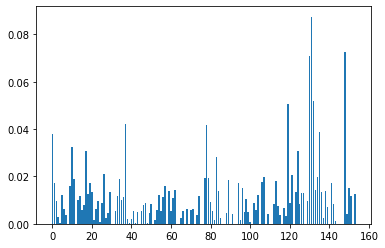

In [11]:
# FEATURE SELECTION - Detecting irrelevant features for salary inference

X_fs = df.drop(columns=['Job Title', 'Salary Estimate', 'Job Description', 'Location', 'Rating', 'Headquarters', 'Size', 'scope_DataAnalyst', 'scope_DataEngineer', 
                        'scope_DataScientist', 'desc_words', 'salary', 'location_cat'], errors='ignore')
y_fs = df['salary']
X_fs = X_fs.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size=test_set_size)
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

feature_scores = {}

for i in range(len(fs.scores_)):
  #print('Feature ' + fs.feature_names_in_[i] + ': ' + str(fs.scores_[i]))
  feature_scores[fs.feature_names_in_[i]] = fs.scores_[i]

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

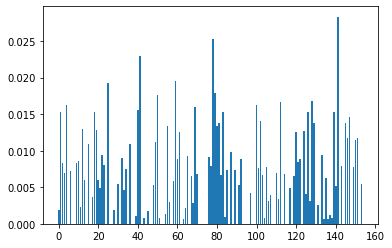

In [12]:
# FEATURE SELECTION - Detecting irrelevant features for rating inference

# Cleaning dataset to predict ratings

df_rating = df[df['Rating'] != -1]
X_fs = df_rating.drop(columns=['Job Title', 'Salary Estimate', 'Job Description', 'Location', 'Rating', 'Headquarters', 'Size', 'scope_DataAnalyst', 'scope_DataEngineer', 
                        'scope_DataScientist', 'desc_words', 'salary', 'location_cat'], errors='ignore')

y_fs = df_rating['Rating']

X_train, X_test, y_train, y_test = train_test_split(X_fs, y_fs, test_size=test_set_size)
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

feature_scores_ratings = {}

for i in range(len(fs.scores_)):
  #print('Feature ' + fs.feature_names_in_[i] + ': ' + str(fs.scores_[i]))
  feature_scores_ratings[fs.feature_names_in_[i]] = fs.scores_[i]

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [13]:
# Establishing salary and ratings datasets, with the corresponding relevant features for each one

df_salary = df
df_rating = df

# Cleaning dataset to predict ratings
df_rating = df[df['Rating'] != -1]

# Deleting irrelevant features - salary inference
feature_scores = dict(sorted(feature_scores.items(), key=lambda item: item[1], reverse=True))
relevant_feature_scores = {k: feature_scores[k] for k in list(feature_scores)[:relevant_features_salary]}

for feature in feature_scores.items():
  if feature[0] not in relevant_feature_scores:
    df_salary = df_salary.drop(columns=[feature[0]])


# Deleting irrelevant features - rating inference
feature_scores_ratings = dict(sorted(feature_scores_ratings.items(), key=lambda item: item[1], reverse=True))
relevant_feature_scores_ratings = {k: feature_scores_ratings[k] for k in list(feature_scores_ratings)[:relevant_features_rating]}

for feature in feature_scores_ratings.items():
  if feature[0] not in relevant_feature_scores_ratings:
    df_rating = df_rating.drop(columns=[feature[0]])

#print(df_salary)
#print(df_rating)
#print(df_salary.columns.tolist())
#print(df_rating.columns.tolist())

In [14]:
# Using one hot encoding to encode categorical feature 'Location'

encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_salary[['location_cat']])
encoded_column_names = list(encoder.get_feature_names_out(['location_cat']))
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=encoded_column_names)

df_salary = df_salary.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)

df_salary = pd.concat([df_salary, df_encoded], axis=1).drop(columns=['location_cat'])

encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_rating[['location_cat']])
encoded_column_names = list(encoder.get_feature_names_out(['location_cat']))
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=encoded_column_names)

df_rating = df_rating.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)

df_rating = pd.concat([df_rating, df_encoded], axis=1).drop(columns=['location_cat'])

#print(df_salary)
#print(df_rating)

In [15]:
# Saving datasets

df.to_csv('output/dataset.csv')
df_salary.to_csv('output/dataset_salary.csv')
df_rating.to_csv('output/dataset_rating.csv')

files = ['output/dataset.csv', 'output/dataset_salary.csv', 'output/dataset_rating.csv']
for csv_file in files:
  with open(csv_file, 'rb') as f_in, gzip.open(csv_file + '.gz', 'wb') as f_out:
    f_out.writelines(f_in)

In [16]:
# PREDICTING SALARIES
# Using lazypredict to benchmark several regression algorithms using R2-score as metric. The best one will be selected for training and inference

# Excluding those which takes a huge amount of time (and give low R2-score)

excluded_regressors = [
    'QuantileRegressor', 'TheilSenRegressor'
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in excluded_regressors))
]

# Prepare dataset
X_lazy = df_salary.drop(columns=['Job Title', 'Salary Estimate', 'Job Description', 'Location', 'Rating', 'Headquarters', 'Size', 'desc_words', 'salary'])
y_lazy = df_salary['salary']
X_lazy = X_lazy.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_lazy, y_lazy, test_size=test_set_size)

reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None, regressors=REGRESSORS)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  2%|▏         | 1/53 [00:00<00:21,  2.42it/s]

{'Model': 'ARDRegression', 'R-Squared': 0.39472875682976727, 'Adjusted R-Squared': 0.364648610199489, 'RMSE': 28.81579786648288, 'Time taken': 0.4115581512451172}


  4%|▍         | 2/53 [00:00<00:16,  3.17it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.23483422701104006, 'Adjusted R-Squared': 0.1968078067776493, 'RMSE': 32.39913356523694, 'Time taken': 0.2434825897216797}


  8%|▊         | 4/53 [00:01<00:14,  3.45it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.3172943182726454, 'Adjusted R-Squared': 0.283365914695892, 'RMSE': 30.60359086202285, 'Time taken': 0.4774653911590576}
{'Model': 'BayesianRidge', 'R-Squared': 0.3961281055472041, 'Adjusted R-Squared': 0.36611750230773177, 'RMSE': 28.78246844312219, 'Time taken': 0.13261151313781738}


 11%|█▏        | 6/53 [00:01<00:10,  4.57it/s]

{'Model': 'CCA', 'R-Squared': 0.19756791212971425, 'Adjusted R-Squared': 0.1576894689749485, 'RMSE': 33.17873106142141, 'Time taken': 0.17033958435058594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.036500691140812225, 'Adjusted R-Squared': -0.01138230481461422, 'RMSE': 36.35643845969957, 'Time taken': 0.1530759334564209}
{'Model': 'DummyRegressor', 'R-Squared': -0.0015923743027170811, 'Adjusted R-Squared': -0.05136848017715523, 'RMSE': 37.068168910690645, 'Time taken': 0.03206992149353027}
{'Model': 'ElasticNet', 'R-Squared': 0.3443265842619532, 'Adjusted R-Squared': 0.3117416023889108, 'RMSE': 29.991584890124308, 'Time taken': 0.0556790828704834}


 19%|█▉        | 10/53 [00:02<00:08,  5.15it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3962259102374086, 'Adjusted R-Squared': 0.3662201675946616, 'RMSE': 28.78013750635551, 'Time taken': 0.480501651763916}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.05514553257460253, 'Adjusted R-Squared': 0.008189128738915974, 'RMSE': 36.00295014416242, 'Time taken': 0.16136860847473145}


 21%|██        | 11/53 [00:08<01:05,  1.57s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.07222853553524433, 'Adjusted R-Squared': 0.026121105180026083, 'RMSE': 35.67599825712707, 'Time taken': 5.928481817245483}
{'Model': 'GammaRegressor', 'R-Squared': 0.32045575876897003, 'Adjusted R-Squared': 0.2866844692047612, 'RMSE': 30.532649823934083, 'Time taken': 0.06334257125854492}


 25%|██▍       | 13/53 [00:31<03:43,  5.59s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.188246841054296, 'Adjusted R-Squared': -4.446086987094571, 'RMSE': 84.36570573393205, 'Time taken': 22.86102294921875}


 26%|██▋       | 14/53 [00:32<02:57,  4.55s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.42723169406090866, 'Adjusted R-Squared': 0.3987668449172689, 'RMSE': 28.031421243043635, 'Time taken': 0.963822603225708}


 30%|███       | 16/53 [00:33<01:42,  2.77s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.44423983565491965, 'Adjusted R-Squared': 0.4166202396086792, 'RMSE': 27.612093530282397, 'Time taken': 1.0051124095916748}
{'Model': 'HuberRegressor', 'R-Squared': 0.3877667833525825, 'Adjusted R-Squared': 0.3573406477373775, 'RMSE': 28.98104711378588, 'Time taken': 0.10900402069091797}
IsotonicRegression model failed to execute
Isotonic regression input X should be a 1d array or 2d array with 1 feature


 34%|███▍      | 18/53 [00:33<00:58,  1.68s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.31208257581074006, 'Adjusted R-Squared': 0.27789516442678885, 'RMSE': 30.72018194550851, 'Time taken': 0.3707313537597656}


 36%|███▌      | 19/53 [00:40<01:38,  2.90s/it]

{'Model': 'KernelRidge', 'R-Squared': -6.580217384058597, 'Adjusted R-Squared': -6.956931217690601, 'RMSE': 101.97564451661472, 'Time taken': 6.913214683532715}
{'Model': 'Lars', 'R-Squared': 0.39572655432917125, 'Adjusted R-Squared': 0.3656959952109845, 'RMSE': 28.792036461324432, 'Time taken': 0.08709073066711426}


 40%|███▉      | 21/53 [00:41<00:58,  1.83s/it]

{'Model': 'LarsCV', 'R-Squared': 0.3950629930686177, 'Adjusted R-Squared': 0.3649994569665732, 'RMSE': 28.807840596089846, 'Time taken': 0.3424248695373535}
{'Model': 'Lasso', 'R-Squared': 0.37324646777029247, 'Adjusted R-Squared': 0.34209871647160395, 'RMSE': 29.322704498292584, 'Time taken': 0.06567025184631348}


 43%|████▎     | 23/53 [00:41<00:37,  1.24s/it]

{'Model': 'LassoCV', 'R-Squared': 0.3952933544406402, 'Adjusted R-Squared': 0.3652412666007204, 'RMSE': 28.802355028584255, 'Time taken': 0.3576805591583252}
{'Model': 'LassoLars', 'R-Squared': -0.0015923743027170811, 'Adjusted R-Squared': -0.05136848017715523, 'RMSE': 37.068168910690645, 'Time taken': 0.05121350288391113}


 49%|████▉     | 26/53 [00:41<00:19,  1.36it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.3950629930686177, 'Adjusted R-Squared': 0.3649994569665732, 'RMSE': 28.807840596089846, 'Time taken': 0.2709810733795166}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3955724510035725, 'Adjusted R-Squared': 0.36553423341708335, 'RMSE': 28.79570753586599, 'Time taken': 0.15835809707641602}


 51%|█████     | 27/53 [00:42<00:15,  1.66it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.3956989425320473, 'Adjusted R-Squared': 0.3656670111912157, 'RMSE': 28.792694268475927, 'Time taken': 0.12350320816040039}


 53%|█████▎    | 28/53 [00:42<00:13,  1.90it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.3764249014066512, 'Adjusted R-Squared': 0.3454351086280726, 'RMSE': 29.24825838280651, 'Time taken': 0.28208422660827637}


 64%|██████▍   | 34/53 [00:56<00:26,  1.39s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.42984472703515586, 'Adjusted R-Squared': 0.40150973771205445, 'RMSE': 27.967406912424927, 'Time taken': 13.661570310592651}
MultiOutputRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimator'
MultiTaskElasticNet model failed to execute
For mono-task outputs, use ElasticNet
MultiTaskElasticNetCV model failed to execute
For mono-task outputs, use ElasticNetCVCV
MultiTaskLasso model failed to execute
For mono-task outputs, use ElasticNet
MultiTaskLassoCV model failed to execute
For mono-task outputs, use LassoCVCV


 68%|██████▊   | 36/53 [00:59<00:25,  1.49s/it]

{'Model': 'NuSVR', 'R-Squared': 0.2950645814360786, 'Adjusted R-Squared': 0.26003142730138673, 'RMSE': 31.097844993283193, 'Time taken': 3.4660139083862305}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3275686545266483, 'Adjusted R-Squared': 0.29415085432736654, 'RMSE': 30.37243446291158, 'Time taken': 0.03991508483886719}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3275686545266483, 'Adjusted R-Squared': 0.29415085432736654, 'RMSE': 30.37243446291158, 'Time taken': 0.14751243591308594}


 75%|███████▌  | 40/53 [01:00<00:10,  1.24it/s]

{'Model': 'PLSCanonical', 'R-Squared': -1.4254277975272966, 'Adjusted R-Squared': -1.5459642092831989, 'RMSE': 57.68326095588533, 'Time taken': 0.05413031578063965}
{'Model': 'PLSRegression', 'R-Squared': 0.34983874981080676, 'Adjusted R-Squared': 0.3175277058620104, 'RMSE': 29.86525103361985, 'Time taken': 0.0673513412475586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5725904295862618, 'Adjusted R-Squared': -0.650743408511155, 'RMSE': 46.447617582021955, 'Time taken': 0.06978178024291992}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4053971195912013, 'Adjusted R-Squared': 0.37584715826179427, 'RMSE': 28.56071877963058, 'Time taken': 0.10031318664550781}


 79%|███████▉  | 42/53 [01:00<00:07,  1.44it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -2.587426223640163e+23, 'Adjusted R-Squared': -2.716013466269553e+23, 'RMSE': 18840378192860.67, 'Time taken': 0.7155933380126953}


 81%|████████  | 43/53 [01:01<00:06,  1.60it/s]

RadiusNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 89%|████████▊ | 47/53 [01:05<00:04,  1.36it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.36800992864841653, 'Adjusted R-Squared': 0.33660193722367115, 'RMSE': 29.44494560820013, 'Time taken': 4.129686117172241}
RegressorChain model failed to execute
__init__() missing 1 required positional argument: 'base_estimator'
{'Model': 'Ridge', 'R-Squared': 0.39571390537472373, 'Adjusted R-Squared': 0.36568271764183113, 'RMSE': 28.792337804412096, 'Time taken': 0.03888082504272461}
{'Model': 'RidgeCV', 'R-Squared': 0.3957534576084504, 'Adjusted R-Squared': 0.36572423550171873, 'RMSE': 28.791395519028107, 'Time taken': 0.11216044425964355}


 91%|█████████ | 48/53 [01:05<00:03,  1.60it/s]

{'Model': 'SGDRegressor', 'R-Squared': -2383943.5845969417, 'Adjusted R-Squared': -2502418.4063769113, 'RMSE': 57187.84173387262, 'Time taken': 0.10393548011779785}


100%|██████████| 53/53 [01:10<00:00,  1.33s/it]

{'Model': 'SVR', 'R-Squared': 0.3028913235153087, 'Adjusted R-Squared': 0.2682471347445542, 'RMSE': 30.924726880658767, 'Time taken': 4.8881964683532715}
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3956989425320473, 'Adjusted R-Squared': 0.3656670111912157, 'RMSE': 28.792694268475927, 'Time taken': 0.06462669372558594}
{'Model': 'TweedieRegressor', 'R-Squared': 0.32193224510470575, 'Adjusted R-Squared': 0.288234332437182, 'RMSE': 30.4994617312921, 'Time taken': 0.04825711250305176}
VotingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


In [17]:
# Printing final result of lazypredict

print(models)

                                        Adjusted R-Squared  \
Model                                                        
HistGradientBoostingRegressor                         0.42   
MLPRegressor                                          0.40   
GradientBoostingRegressor                             0.40   
PoissonRegressor                                      0.38   
ElasticNetCV                                          0.37   
BayesianRidge                                         0.37   
RidgeCV                                               0.37   
Lars                                                  0.37   
Ridge                                                 0.37   
TransformedTargetRegressor                            0.37   
LinearRegression                                      0.37   
LassoLarsIC                                           0.37   
LassoCV                                               0.37   
LassoLarsCV                                           0.36   
LarsCV  

In [18]:
# The regression algorithm HistGradientBoostingRegressor is the one to be used

model = HistGradientBoostingRegressor().fit(X_train, y_train)
test_prediction = model.predict(X_test)

# Evaluate result

R2 = model.score(X_test, y_test)

average = np.mean(abs(y_test - test_prediction))
sigma = np.std((y_test - test_prediction))

max = np.max(df['salary'].values.tolist())
min = np.min(df['salary'].values.tolist())
domain = max - min

print('R2-score: ', R2)
print('Mean error in prediction: ', average)
print('Prediction error variance: ', sigma)
print('Max, min, domain: ', max, ", ", min, ", ", domain)

print('Mean error in prediction (%): ', average/domain)
print('Prediction error variance (%): ', sigma/domain) 

R2-score:  0.44423983565491965
Mean error in prediction:  21.242346386549908
Prediction error variance:  27.595268074164174
Max, min, domain:  225.0 ,  33.5 ,  191.5
Mean error in prediction (%):  0.11092609079138332
Prediction error variance (%):  0.14410061657526985


In [19]:
# Saving the model
joblib.dump(model, "models/model_salary.joblib")

with open("models/model_salary.joblib", 'rb') as f_in, gzip.open("models/model_salary.joblib.gz", 'wb') as f_out:
    f_out.writelines(f_in)

In [20]:
# One case inference code: getting salary of a random user

# Inference params
number_of_abilities = 15
scope_example = 2.0

columns = X_train.columns.values.tolist()
total_abilities = len(columns) - 1

abilities_indexes = [randint(0, (total_abilities - 1)) for p in range(0, number_of_abilities)]
abilities = [0.0] * (total_abilities)

for ab in abilities_indexes:
  abilities[ab] = 1.0

list_row = [scope_example] + abilities

X_row = X_train[0:0]
X_row.loc[len(X_row)] = list_row

predictions = model.predict(X_row)
predictions

array([92.33463039])

In [21]:
# PREDICTING RATINGS
# Using lazypredict to benchmark several regression algorithms using R2-score as metric. The best one will be selected for train and inference

# Excluding those which takes a huge amount of time (and give low R2-score)

excluded_regressors = [
    'QuantileRegressor', 'TheilSenRegressor'
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in excluded_regressors))
]

# Prepare dataset
X_lazy = df_rating.drop(columns=['Job Title', 'Salary Estimate', 'Job Description', 'Location', 'Rating', 'Headquarters', 'Size', 'scope_DataAnalyst', 'scope_DataEngineer', 
                        'scope_DataScientist', 'desc_words', 'salary'])
y_lazy = df_rating['Rating']
X_lazy = X_lazy.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X_lazy, y_lazy, test_size=test_set_size)

reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None, regressors=REGRESSORS)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  0%|          | 0/53 [00:00<?, ?it/s]

{'Model': 'ARDRegression', 'R-Squared': 0.05075920014822155, 'Adjusted R-Squared': -0.014006367863719227, 'RMSE': 0.6307387144139858, 'Time taken': 0.08400893211364746}


  4%|▍         | 2/53 [00:00<00:11,  4.26it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.02910772578031917, 'Adjusted R-Squared': -0.09932251892453126, 'RMSE': 0.6567373399584928, 'Time taken': 0.3845670223236084}


  8%|▊         | 4/53 [00:01<00:14,  3.34it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.17420704117608254, 'Adjusted R-Squared': 0.11786417217293443, 'RMSE': 0.5882973309486758, 'Time taken': 0.569760799407959}
{'Model': 'BayesianRidge', 'R-Squared': 0.06094162729254615, 'Adjusted R-Squared': -0.003129205855653794, 'RMSE': 0.6273466524195687, 'Time taken': 0.1657719612121582}


 11%|█▏        | 6/53 [00:01<00:10,  4.47it/s]

{'Model': 'CCA', 'R-Squared': -0.5000247520692209, 'Adjusted R-Squared': -0.6023696524516144, 'RMSE': 0.7928855498447155, 'Time taken': 0.15179777145385742}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.11350474713340564, 'Adjusted R-Squared': -0.18947784841955806, 'RMSE': 0.683136242656283, 'Time taken': 0.16097712516784668}
{'Model': 'DummyRegressor', 'R-Squared': -0.00011606519349660616, 'Adjusted R-Squared': -0.06835279190208121, 'RMSE': 0.6474205674074496, 'Time taken': 0.03389382362365723}
{'Model': 'ElasticNet', 'R-Squared': -0.00011606519349660616, 'Adjusted R-Squared': -0.06835279190208121, 'RMSE': 0.6474205674074496, 'Time taken': 0.04171419143676758}


 19%|█▉        | 10/53 [00:02<00:07,  5.48it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.054352869817211436, 'Adjusted R-Squared': -0.010167506397879, 'RMSE': 0.6295436456997442, 'Time taken': 0.3892490863800049}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.09815886877342161, 'Adjusted R-Squared': -0.17308493907567435, 'RMSE': 0.6784125555687663, 'Time taken': 0.1743922233581543}


 21%|██        | 11/53 [00:09<01:16,  1.81s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.05698340303126326, 'Adjusted R-Squared': -0.1291001203986617, 'RMSE': 0.6655725072259138, 'Time taken': 7.042081117630005}
{'Model': 'GammaRegressor', 'R-Squared': 0.0521216730054096, 'Adjusted R-Squared': -0.012550935107936034, 'RMSE': 0.63028589308158, 'Time taken': 0.04690885543823242}


 25%|██▍       | 13/53 [00:25<02:58,  4.47s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -12.597086828832508, 'Adjusted R-Squared': -13.524799851612949, 'RMSE': 2.3871748247418747, 'Time taken': 16.706206560134888}


 26%|██▋       | 14/53 [00:26<02:23,  3.67s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.08422256170437359, 'Adjusted R-Squared': 0.02174015895367265, 'RMSE': 0.6195213250250658, 'Time taken': 0.8842208385467529}


 30%|███       | 16/53 [00:28<01:24,  2.29s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.14776005872678688, 'Adjusted R-Squared': 0.08961274364336291, 'RMSE': 0.5976435438505837, 'Time taken': 1.1027934551239014}
{'Model': 'HuberRegressor', 'R-Squared': 0.05351024325145637, 'Adjusted R-Squared': -0.011067624369567763, 'RMSE': 0.6298240632391803, 'Time taken': 0.10912775993347168}
IsotonicRegression model failed to execute
Isotonic regression input X should be a 1d array or 2d array with 1 feature


 34%|███▍      | 18/53 [00:28<00:48,  1.39s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.0057853562214117416, 'Adjusted R-Squared': -0.06204872354018742, 'RMSE': 0.6455076121700185, 'Time taken': 0.27655625343322754}


 36%|███▌      | 19/53 [00:32<01:09,  2.03s/it]

{'Model': 'KernelRidge', 'R-Squared': -33.90322045385474, 'Adjusted R-Squared': -36.284625570968196, 'RMSE': 3.8246706263071357, 'Time taken': 4.162345886230469}
{'Model': 'Lars', 'R-Squared': 0.05993134284737678, 'Adjusted R-Squared': -0.004208420803973878, 'RMSE': 0.6276840266483328, 'Time taken': 0.07888507843017578}


 40%|███▉      | 21/53 [00:32<00:41,  1.31s/it]

{'Model': 'LarsCV', 'R-Squared': 0.052970238526877655, 'Adjusted R-Squared': -0.01164447297266702, 'RMSE': 0.63000370568666, 'Time taken': 0.33993053436279297}
{'Model': 'Lasso', 'R-Squared': -0.00011606519349660616, 'Adjusted R-Squared': -0.06835279190208121, 'RMSE': 0.6474205674074496, 'Time taken': 0.04715776443481445}


 43%|████▎     | 23/53 [00:33<00:27,  1.09it/s]

{'Model': 'LassoCV', 'R-Squared': 0.054373533719381584, 'Adjusted R-Squared': -0.010145432622300943, 'RMSE': 0.629536767394424, 'Time taken': 0.44517064094543457}
{'Model': 'LassoLars', 'R-Squared': -0.00011606519349660616, 'Adjusted R-Squared': -0.06835279190208121, 'RMSE': 0.6474205674074496, 'Time taken': 0.08614635467529297}


 49%|████▉     | 26/53 [00:34<00:15,  1.73it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.052970238526877655, 'Adjusted R-Squared': -0.01164447297266702, 'RMSE': 0.63000370568666, 'Time taken': 0.3440392017364502}
{'Model': 'LassoLarsIC', 'R-Squared': 0.051942202393856274, 'Adjusted R-Squared': -0.012742650785336318, 'RMSE': 0.6303455591998779, 'Time taken': 0.14775586128234863}


 51%|█████     | 27/53 [00:34<00:12,  2.07it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.05967490514972662, 'Adjusted R-Squared': -0.004482354939988831, 'RMSE': 0.6277696325611976, 'Time taken': 0.13776040077209473}


 53%|█████▎    | 28/53 [00:36<00:21,  1.15it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.04723918041300712, 'Adjusted R-Squared': -0.017766554348614072, 'RMSE': 0.6319070998520131, 'Time taken': 2.1034159660339355}


 62%|██████▏   | 33/53 [00:44<00:22,  1.14s/it]

{'Model': 'MLPRegressor', 'R-Squared': -0.045704947648404604, 'Adjusted R-Squared': -0.11705214945212083, 'RMSE': 0.6620120151312332, 'Time taken': 8.282472133636475}
MultiOutputRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimator'
MultiTaskElasticNet model failed to execute
For mono-task outputs, use ElasticNet
MultiTaskElasticNetCV model failed to execute
For mono-task outputs, use ElasticNetCVCV
MultiTaskLasso model failed to execute
For mono-task outputs, use ElasticNet
MultiTaskLassoCV model failed to execute
For mono-task outputs, use LassoCVCV


 70%|██████▉   | 37/53 [00:48<00:16,  1.00s/it]

{'Model': 'NuSVR', 'R-Squared': 0.1487844900687092, 'Adjusted R-Squared': 0.09070707071433437, 'RMSE': 0.5972842384219305, 'Time taken': 3.925266742706299}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.021039495628709992, 'Adjusted R-Squared': -0.04575381238835252, 'RMSE': 0.6405364900790996, 'Time taken': 0.0482478141784668}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.018299864247421915, 'Adjusted R-Squared': -0.04868036555237509, 'RMSE': 0.6414321379861649, 'Time taken': 0.13735246658325195}


 74%|███████▎  | 39/53 [00:48<00:10,  1.38it/s]

{'Model': 'PLSCanonical', 'R-Squared': -0.7363302639735516, 'Adjusted R-Squared': -0.8547980076905617, 'RMSE': 0.8530558346805078, 'Time taken': 0.056014299392700195}
{'Model': 'PLSRegression', 'R-Squared': 0.06276178358155537, 'Adjusted R-Squared': -0.00118486247318339, 'RMSE': 0.6267383713798681, 'Time taken': 0.0764920711517334}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.1344410127505675, 'Adjusted R-Squared': -1.280071378196678, 'RMSE': 0.9458088400817918, 'Time taken': 0.08241438865661621}


 77%|███████▋  | 41/53 [00:49<00:06,  1.89it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.061949278534839225, 'Adjusted R-Squared': -0.0020528037705025426, 'RMSE': 0.6270099767008818, 'Time taken': 0.06162738800048828}
{'Model': 'RANSACRegressor', 'R-Squared': -4.4620565397257267e+24, 'Adjusted R-Squared': -4.7664973374051527e+24, 'RMSE': 1367504691028.9175, 'Time taken': 0.897310733795166}


 81%|████████  | 43/53 [00:50<00:05,  1.83it/s]

RadiusNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 83%|████████▎ | 44/53 [00:55<00:11,  1.30s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.21862733954000446, 'Adjusted R-Squared': 0.16531521453274078, 'RMSE': 0.5722560542850893, 'Time taken': 4.836252450942993}
RegressorChain model failed to execute
__init__() missing 1 required positional argument: 'base_estimator'
{'Model': 'Ridge', 'R-Squared': 0.0599346983318928, 'Adjusted R-Squared': -0.00420483637874991, 'RMSE': 0.6276829064184986, 'Time taken': 0.041272640228271484}


 91%|█████████ | 48/53 [00:55<00:03,  1.51it/s]

{'Model': 'RidgeCV', 'R-Squared': 0.05996464911533195, 'Adjusted R-Squared': -0.004172842089066542, 'RMSE': 0.6276729072490218, 'Time taken': 0.17548084259033203}
{'Model': 'SGDRegressor', 'R-Squared': -2347289.971275912, 'Adjusted R-Squared': -2507442.835615206, 'RMSE': 991.847160669111, 'Time taken': 0.10098505020141602}


100%|██████████| 53/53 [00:59<00:00,  1.13s/it]

{'Model': 'SVR', 'R-Squared': 0.1476606136906865, 'Adjusted R-Squared': 0.0895065135910158, 'RMSE': 0.5976784113493162, 'Time taken': 4.004381418228149}
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.05967490514972662, 'Adjusted R-Squared': -0.004482354939988831, 'RMSE': 0.6277696325611976, 'Time taken': 0.07575130462646484}
{'Model': 'TweedieRegressor', 'R-Squared': 0.05197174002413296, 'Adjusted R-Squared': -0.012711097837762919, 'RMSE': 0.6303357396197078, 'Time taken': 0.09615874290466309}
VotingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


In [22]:
# Printing final result of lazypredict

print(models)

                                         Adjusted R-Squared  \
Model                                                         
RandomForestRegressor                                  0.17   
BaggingRegressor                                       0.12   
NuSVR                                                  0.09   
HistGradientBoostingRegressor                          0.09   
SVR                                                    0.09   
GradientBoostingRegressor                              0.02   
PLSRegression                                         -0.00   
PoissonRegressor                                      -0.00   
BayesianRidge                                         -0.00   
RidgeCV                                               -0.00   
Ridge                                                 -0.00   
Lars                                                  -0.00   
TransformedTargetRegressor                            -0.00   
LinearRegression                                      -

In [23]:
# The regression algorithm RandomForestRegressor is the one to be used

model_rating = RandomForestRegressor(max_depth=10).fit(X_train, y_train)
test_prediction = model_rating.predict(X_test)

# Evaluate result

R2 = model_rating.score(X_test, y_test)

average = np.mean(abs(y_test - test_prediction))
sigma = np.std((y_test - test_prediction))

max = np.max(df_rating['Rating'].values.tolist())
min = np.min(df_rating['Rating'].values.tolist())
domain = max - min

print('R2-score: ', R2)
print('Mean error in prediction: ', average)
print('Prediction error variance: ', sigma)
print('Max, min, domain: ', max, ", ", min, ", ", domain)

print('Mean error in prediction (%): ', average/domain)
print('Prediction error variance (%): ', sigma/domain) 

R2-score:  0.10759220318083773
Mean error in prediction:  0.4526162192283656
Prediction error variance:  0.6115217077375872
Max, min, domain:  5.0 ,  1.0 ,  4.0
Mean error in prediction (%):  0.1131540548070914
Prediction error variance (%):  0.1528804269343968


In [24]:
# Saving the model
joblib.dump(model_rating, "models/model_rating.joblib")

with open("models/model_rating.joblib", 'rb') as f_in, gzip.open("models/model_rating.joblib.gz", 'wb') as f_out:
    f_out.writelines(f_in)

In [25]:
# One case inference code: getting rating of a random user

# Inference params
number_of_abilities = 15
scope_example = 2.0

columns = X_train.columns.values.tolist()
total_abilities = len(columns) - 1

abilities_indexes = [randint(0, (total_abilities - 1)) for p in range(0, number_of_abilities)]
abilities = [0.0] * (total_abilities)

for ab in abilities_indexes:
  abilities[ab] = 1.0

list_row = [scope_example] + abilities

X_row = X_train[0:0]
X_row.loc[len(X_row)] = list_row

predictions = model_rating.predict(X_row)
predictions

array([3.92853537])